# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here](http://nlp.stanford.edu:8080/corenlp/) to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For NLP
import nltk
from nltk.tag import StanfordNERTagger
from nltk.tag import StanfordPOSTagger
from nltk.parse import stanford
from nltk.tokenize import word_tokenize
from nltk.tree import Tree
from nltk.draw.tree import TreeView
from nltk.tokenize import sent_tokenize

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

%matplotlib inline

You need to run this _once_ to download everything, you will also need [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) if you are using Windows or MacOS.

In [4]:
lucem_illud.setupStanfordNLP()

Starting downloads, this will take 5-10 minutes
../stanford-NLP/parser already exists, skipping download
Downloaded ner, extracting to ../stanford-NLP/ner
Downloaded postagger, extracting to ../stanford-NLP/postagger
Downloaded core, extracting to ../stanford-NLP/core
Done setting up the Stanford NLP collection


In [6]:
import lucem_illud.stanford as stanford

/Users/czd/anaconda3/lib/python3.6/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/Users/czd/anaconda3/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


In [67]:
stanford.startCoreServer()

Starting server on http://localhost:9000 , please wait a few seconds
click Kernel -> Then Interupt to stop         (((っ･д･)っ               
Exiting (ノ≧▽≦)ノ


In [7]:
text = ['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [word_tokenize(t) for t in text]
print('\n'.join(text))

I saw the elephant in my pajamas.
The quick brown fox jumped over the lazy dog.
While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.
Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo


## Introduction

In this homework, I intend to extract claims from cigarettes advertising slogans and anti-smoking slogans, to see what are the different stories behind the slogans.

My work contains 4 parts: POS Tagging, Name Entity Recognition, Parsing and Information Extraction.

To this end, I will use two modest datasets:

1) **Cigarettes Advertisng Slogans**: This corpus contains 61 slogans in total, which credit to SRITA (Stanford University Research into the Impact of Tobacco Advertising). These slogans are from some famous cigarettes brands including Marlboro, Camel, Chesterfield, Lucky Strikes, Embassy, Newport, parliament, Kent and Kools.

2) **Anti-smoking Slogans**: This corpus contains 68 slogans in total, which I collected from Brandongaille (“Marketing Expert & Blog Master”), a website shares marketing materials.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional frequencies (e.g., adjectives associated with nouns of interest or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In this part, I am going to perform POS tagging on my two subset respectively, to classify each word by its semantic role in a sentence. Specifically, I will look into nouns, verbs and adjectives, and also conditional frequencies.

## Advertisement Slogan

### POS Tagging

In [8]:
smokeDF = pandas.read_excel('../data/smoke.xls', index_col=0)

In [9]:
smokeDF[:5]

,brand,slogan-text
0,Camel,More doctors smoke Camels than any other cigar...
1,Camel,Not one single case of throat irritation!
2,Camel,See how your throat reacts to the delightfully...
3,Camel,"Your "" T-Zone"" will tell you! T for taste, T f..."
4,Camel,"For digestions sake, smoke Camels"


In [10]:
smokeDF['sentences'] = smokeDF['slogan-text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])

In [11]:
smokeDF[:5]

,brand,slogan-text,sentences
0,Camel,More doctors smoke Camels than any other cigar...,"[[More, doctors, smoke, Camels, than, any, oth..."
1,Camel,Not one single case of throat irritation!,"[[Not, one, single, case, of, throat, irritati..."
2,Camel,See how your throat reacts to the delightfully...,"[[See, how, your, throat, reacts, to, the, del..."
3,Camel,"Your "" T-Zone"" will tell you! T for taste, T f...","[[Your, ``, T-Zone, '', will, tell, you, !], [..."
4,Camel,"For digestions sake, smoke Camels","[[For, digestions, sake, ,, smoke, Camels]]"


In [12]:
smokeDF['POS_sents'] = smokeDF['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [13]:
smokeDF['POS_sents']

0     [[(More, JJR), (doctors, NNS), (smoke, VBP), (...
1     [[(Not, RB), (one, CD), (single, JJ), (case, N...
2     [[(See, VB), (how, WRB), (your, PRP$), (throat...
3     [[(Your, PRP$), (``, ``), (T-Zone, NN), ('', '...
4     [[(For, IN), (digestions, NNS), (sake, NN), (,...
5     [[(Give, VB), (your, PRP$), (throat, NN), (a, ...
6     [[(They, PRP), (’, VBP), (re, RB), (smooth, JJ...
7     [[(It, PRP), (takes, VBZ), (healthy, JJ), (ner...
8     [[(Camels, NNS), (never, RB), (get, VB), (on, ...
9     [[(They, PRP), (don, VBP), (’, CD), (t, NN), (...
10    [[(Fatigued, VBN), (?, .)], [(Get, VB), (a, DT...
11    [[(Camels, NNS), (agree, VBP), (with, IN), (yo...
12    [[(It, PRP), (’, RB), (s, VBZ), (a, DT), (psyc...
13    [[(Ivory, NNP), (tips, NNS), (protect, VBP), (...
14    [[(Gee, NNP), (,, ,), (Mommy, NNP), (you, PRP)...
15    [[(Refreshes, NNS), (as, IN), (you, PRP), (smo...
16    [[(It, PRP), (’, RB), (s, VBZ), (toasted, VBN)...
17    [[(No, DT), (Throat, FW), (Irritation—No, 

Count the nouns (NN, NNS, NNP, NNPS)

In [14]:
countTarget = 'NN' #NNS, NNP, NNPS
targetCounts = {}
for entry in smokeDF['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets

[('throat', 19),
 ('cigarette', 4),
 ('irritation', 3),
 ('taste', 3),
 ('protection', 3),
 ('T', 2),
 ('smoke', 2),
 ('t', 2),
 ('Pleasure', 2),
 ('flavor', 2),
 ('doctor', 2),
 ('s', 2),
 ('content', 2),
 ('smoking', 2),
 ('case', 1),
 ('mildness', 1),
 ('T-Zone', 1),
 ('sake', 1),
 ('vacation', 1),
 ('wind', 1),
 ('lift', 1),
 ('camel', 1),
 ('fact', 1),
 ('disposition', 1),
 ('cough', 1),
 ('light', 1),
 ('weight', 1),
 ('answer', 1),
 ('rasp', 1),
 ('voice', 1),
 ('puff', 1),
 ('Smoke', 1),
 ('evidence', 1),
 ('mouth', 1),
 ('Nose', 1),
 ('accessory', 1),
 ('selling', 1),
 ('degree', 1),
 ('health', 1),
 ('satisfaction', 1),
 ('change', 1),
 ('menthol', 1),
 ('cold', 1),
 ('holiday', 1),
 ('carton', 1),
 ('way', 1),
 ('mile', 1),
 ('lot', 1),
 ('heart', 1),
 ('kind', 1)]

The most common nouns is **Throat**. Nouns appeared in advertising slogans also includes some other words related to health: doctor, organs, digestion. Also there are words related to cigarette brands (e.g. Lucky). Positive nouns in this corpus are protection, pleasure, mildness, vacation, wind,refreshes, while a little amount of negative nouns also exist like irritation; In addition, advertising slogans mentions nouns related to marketing point and products' feature, like flavor, taste and toast.

Top verbs (VB, VBD, VBG, VBN, VBP, VBZ)

In [15]:
countTarget = 'VB' #VBD, VBG, VBN, VBP, VBZ
targetCounts = {}
for entry in smokeDF['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('get', 3),
 ('prevent', 2),
 ('like', 2),
 ('Come', 2),
 ('See', 1),
 ('tell', 1),
 ('Give', 1),
 ('Get', 1),
 ('enjoy', 1),
 ('Ask', 1),
 ('Reach', 1),
 ('go', 1),
 ('Switch', 1),
 ('Blow', 1),
 ('Slow', 1),
 ('walk', 1),
 ('smoke', 1),
 ('Inhale', 1),
 ('affect', 1)]

As we can see, verbs in advertising slogans are pretty actively and conciously, like get, come, see, tell, enjoy, ask, reach, go, switch, blow, ordered. 

Also look in top adjectives (JJ, JJR, JJS)

In [16]:
countTarget = 'JJ' #JJR, JJS
targetCounts = {}
for entry in smokeDF['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('other', 3),
 ('smooth', 2),
 ('easy', 2),
 ('single', 1),
 ('cool', 1),
 ('healthy', 1),
 ('psychological', 1),
 ('dangerous', 1),
 ('irritating', 1),
 ('light', 1),
 ('kind', 1),
 ('sweet', 1),
 ('excess', 1),
 ('harsh', 1),
 ('extra', 1),
 ('Sensitive', 1),
 ('welcome', 1),
 ('rough', 1),
 ('Gentle', 1),
 ('First', 1)]

It is remarkable that adjectives in advertising slogans are positive: smooth, easy, cool, healthy, light, kind, sweet, gentle; Also, with a goal of marketing, they use some competitive adjectives like finest, best, largest, greatest.

### Conditional Frequencies

Based on our findings above, I am curious about what is the verb that related to the most common noun, "throat"?

In [156]:
NTarget = 'VB'
Word = 'throat'
NResults = set()
for entry in smokeDF['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'prevent'}


It is interesting that in advertising the verb go with "throat" is **prevent** (e.g prevent throat from damage)

Also, I am interest in what adjective modifies the product (cigarettes) in the slogans?

In [159]:
NTarget = 'JJ'
Word = 'cigarette'
NResults = set()
for entry in smokeDF['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'other'}


It is **other**, which shows that in advertising slogans creators usually compare their product with others.

In [173]:
NTarget = 'JJ'
Word = 'smoke'
NResults = set()
for entry in smokeDF['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'light'}


The adjective modifies "smoke" is **light**. So we can see that one of the selling point of cigarettes is its lightness of flavor.

## Anti-smoking Data

### POS Tagging

In [17]:
antiDF = pandas.read_excel('../data/antismoke.xlsx', index_col=0)

In [18]:
antiDF['sentences'] = antiDF['slogan-text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])

In [19]:
antiDF['POS_sents'] = antiDF['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [21]:
countTarget = 'NN' #NNS, NNP, NNPS
targetCounts = {}
for entry in antiDF['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('Smoking', 15),
 ('t', 14),
 ('smoking', 10),
 ('health', 10),
 ('smoke', 7),
 ('Smoke', 3),
 ('Tobacco', 3),
 ('puff', 2),
 ('life', 2),
 ('–', 2),
 ('air', 2),
 ('money', 2),
 ('tobacco', 1),
 ('Put', 1),
 ('Fool', 1),
 ('start', 1),
 ('Cancer', 1),
 ('pocket', 1),
 ('breath', 1),
 ('mouth', 1)]

The most common nouns in anti-smoking slogans are smoking and smoke. Rather than use the entity (cigarettes) like the advertisments do, anti-smoking slogans choose to focus on the behavior smoking. Similarly, there are also nouns related to health: health, lungs, cancer, breath, mouth, life. However, different from the advertising slogans, nouns in anti-smoking slogans are more negative, like killers, drugs, worries,  wrinkles, fool, butthead, cowards.

In [22]:
countTarget = 'VB'#VBD, VBG, VBN, VBP, VBZ
targetCounts = {}
for entry in antiDF['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('Be', 4),
 ('kill', 2),
 ('choke', 2),
 ('Save', 2),
 ('Breathe', 1),
 ('be', 1),
 ('let', 1),
 ('go', 1),
 ('die', 1),
 ('clean', 1),
 ('don', 1),
 ('’', 1),
 ('Live', 1),
 ('Burn', 1),
 ('Please', 1),
 ('keep', 1),
 ('Put', 1),
 ('save', 1),
 ('Smoke', 1),
 ('cause', 1)]

Compare to the advertisement slogans, verbs in the anti-smoking slogans are more negative, such as kill, die, quit, burn, don't, injure and scares.

In [23]:
countTarget = 'JJ'#JJR, JJS
targetCounts = {}
for entry in antiDF['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('dead', 2),
 ('Arsenic', 1),
 ('smart', 1),
 ('tough', 1),
 ('stupid', 1),
 ('my…', 1),
 ('overcrowded', 1),
 ('Quit', 1),
 ('good', 1),
 ('clean', 1),
 ('slow', 1),
 ('painful', 1),
 ('rich', 1),
 ('glamorous', 1),
 ('deep', 1),
 ('ugly', 1),
 ('cool', 1),
 ('wacko', 1),
 ('much', 1),
 ('ash', 1)]

Adjectives in anti-smoking slogans are more negative, like dead, tough, stupid, painful and ugly.

### Conditional Frequencies

Given that **health** appears in both kinds of slogans, let's see what verb go with it in the anti-smoking slogans

In [65]:
NTarget = 'VB'
Word = 'health'
NResults = set()
for entry in antiDF['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'Choose'}


Also, let's see what adjective modifies the top nouns in anti-smoking slogans: **smoking**

In [66]:
NTarget = 'JJ'
Word = 'smoking'
NResults = set()
for entry in antiDF['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'Quit'}


It's **quit** smoking.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed (using your own hand-codings as "ground truth").

### Advertisement Slogans

In [24]:
smokeDF['classified_sents'] = smokeDF['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [63]:
smokeDF['classified_sents']

0     [[(More, O), (doctors, O), (smoke, O), (Camels...
1     [[(Not, O), (one, O), (single, O), (case, O), ...
2     [[(See, O), (how, O), (your, O), (throat, O), ...
3     [[(Your, O), (``, O), (T-Zone, O), ('', O), (w...
4     [[(For, O), (digestions, O), (sake, O), (,, O)...
5     [[(Give, O), (your, O), (throat, O), (a, O), (...
6     [[(They, O), (’, O), (re, O), (smooth, O), (an...
7     [[(It, O), (takes, O), (healthy, O), (nerves, ...
8     [[(Camels, O), (never, O), (get, O), (on, O), ...
9     [[(They, O), (don, O), (’, O), (t, O), (get, O...
10    [[(Fatigued, O), (?, O)], [(Get, O), (a, O), (...
11    [[(Camels, O), (agree, O), (with, O), (your, O...
12    [[(It, O), (’, O), (s, O), (a, O), (psychologi...
13    [[(Ivory, O), (tips, O), (protect, O), (the, O...
14    [[(Gee, O), (,, O), (Mommy, PERSON), (you, O),...
15    [[(Refreshes, O), (as, O), (you, O), (smoke, O)]]
16    [[(It, O), (’, O), (s, O), (toasted, O), (., O)]]
17    [[(No, O), (Throat, O), (Irritation—No, O)

Find the most common entities

In [25]:
entityCounts = {}
for entry in smokeDF['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:50]

[('.', 46),
 ('throat', 19),
 ('a', 19),
 ('your', 16),
 ('to', 15),
 ('the', 8),
 (',', 8),
 ('’', 8),
 ('my', 8),
 ('of', 7),
 ('and', 7),
 ('smoke', 6),
 ('on', 6),
 ('you', 5),
 ('for', 5),
 ('with', 5),
 ('Lucky', 5),
 ('Luckies', 5),
 ('are', 5),
 ('is', 5),
 ('Camels', 4),
 ('cigarette', 4),
 ('...', 4),
 ('They', 4),
 ('get', 4),
 ('s', 4),
 ('The', 4),
 ('I', 4),
 ('throats', 4),
 ('Kools', 4),
 ('other', 3),
 ('irritation', 3),
 ('!', 3),
 ('``', 3),
 ('taste', 3),
 ('For', 3),
 ('It', 3),
 ('No', 3),
 ('light', 3),
 ('protection', 3),
 ('in', 3),
 ('doctors', 2),
 ('any', 2),
 ('Your', 2),
 ("''", 2),
 ('will', 2),
 ('T', 2),
 ('Throat', 2),
 ('re', 2),
 ('smooth', 2)]

Along with the most common entities in advertising slogans, we can identify one kind of specific entity - brand of cigarettes, like **Luckies, Camel, Kools**. The certain entity behind these mentioned entities are acturally **'cigarettes'**

Look into those occurring only twice

In [65]:
[x[0] for x in sortedEntities if x[1] == 2]

['doctors',
 'other',
 'cigarette',
 'T',
 'taste',
 'Throat',
 'They',
 'easy',
 'nerves',
 'never',
 'get',
 't',
 'protect',
 'No',
 'irritants',
 'say',
 'inhale',
 'smoking']

Let's see if there are any organizations in the slogans

In [67]:
OrgCounts = {}
for entry in smokeDF['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[]

Persons.

In [68]:
perCounts = {}
for entry in smokeDF['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'PERSON':
                continue
            elif ent in perCounts:
                perCounts[ent] += 1
            else:
                perCounts[ent] = 1
sortedOrgs = sorted(perCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Mommy', 1)]

In [26]:
LocCounts = {}
for entry in smokeDF['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'LOCATION':
                continue
            elif ent in LocCounts:
                LocCounts[ent] += 1
            else:
                LocCounts[ent] = 1
sortedLoc = sorted(LocCounts.items(), key = lambda x: x[1], reverse = True)
sortedLoc[:10]

[('Chesterfield', 2), ('America', 1)]

As we can see, there are basically no significant person, location and organization entities in our corpus.

## Anti-smoking Slogans

In [27]:
antiDF['classified_sents'] = antiDF['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [28]:
antiDF['classified_sents']

0     [[(Arsenic, O), (kills, O), (if, O), (you, O),...
1     [[(Be, O), (A, O), (Fighter, O), (;, O), (Put,...
2     [[(Be, O), (Cool, O), (–, O), (Don, O), (’, O)...
3     [[(Be, O), (smart, O), (don, O), (’, O), (t, O...
4     [[(Breathe, O), (healthily, O), (,, O), (live,...
5     [[(Bullying, O), (is, O), (like, O), (smoking,...
6     [[(Cancer, O), (cures, O), (smoking, O), (., O)]]
7     [[(Cigarettes, O), (are, O), (killers, O), (th...
8     [[(Cigarettes, O), (burn, O), (holes, O), (in,...
9     [[(Cigarettes, O), (:, O), (You, O), (take, O)...
10    [[(Did, O), (you, O), (know, O), (your, O), (m...
11    [[(Don, O), (’, O), (t, O), (be, O), (a, O), (...
12    [[(Don, O), (’, O), (t, O), (let, O), (your, O...
13    [[(Don, O), (’, O), (t, O), (pout, O), (,, O),...
14    [[(Don, PERSON), (’, PERSON), (t, O), (puff, O...
15    [[(Don, O), (’, O), (t, O), (smoke, O), (–, O)...
16    [[(Don, O), (’, O), (t, O), (smoke, O), (you, ...
17    [[(Don, O), (’, O), (t, O), (smoke, O), (,

Most common entities

In [29]:
entityCounts = {}
for entry in antiDF['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:40]

[('.', 70),
 ('your', 23),
 ('Smoking', 19),
 ('’', 18),
 ('you', 17),
 ('t', 14),
 (',', 13),
 ('is', 11),
 ('smoking', 10),
 ('health', 10),
 ('smoke', 9),
 ('Don', 9),
 ('a', 9),
 ('it', 8),
 ('No-Smoking', 7),
 ('the', 7),
 ('–', 6),
 ('!', 6),
 ('and', 6),
 ('Health', 6),
 ('kills', 4),
 ('Be', 4),
 ('like', 4),
 ('are', 4),
 ('in', 4),
 ('Smoke', 4),
 ('if', 3),
 (';', 3),
 ('The', 3),
 ('don', 3),
 ('can', 3),
 ('kill', 3),
 ('Cigarettes', 3),
 ('away', 3),
 ('?', 3),
 ('out', 3),
 ('to', 3),
 ('will', 3),
 ('not', 3),
 ('of', 3)]

Organizations

In [30]:
OrgCounts = {}
for entry in antiDF['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Tigers', 1), ('Choose', 1), ('Health', 1)]

In [31]:
PerCounts = {}
for entry in antiDF['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'PERSON':
                continue
            elif ent in PerCounts:
                PerCounts[ent] += 1
            else:
                PerCounts[ent] = 1
sortedPers = sorted(PerCounts.items(), key = lambda x: x[1], reverse = True)
sortedPers[:10]

[('Don', 1), ('’', 1), ('Pezing', 1)]

In [32]:
LocCounts = {}
for entry in antiDF['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'LOCATION':
                continue
            elif ent in LocCounts:
                LocCounts[ent] += 1
            else:
                LocCounts[ent] = 1
sortedLoc = sorted(LocCounts.items(), key = lambda x: x[1], reverse = True)
sortedLoc[:10]

[]

Calculating precision, recall and f-measure for the name entities that was classfied here, according to my hand coding classification.

In [122]:
from sklearn.metrics import precision_recall_fscore_support
y_true = np.array(['chesterfield', 'America','Mommy'])
y_pred = np.array(['college', 'America','Mommy'])
precision_recall_fscore_support(y_true, y_pred, average='macro')

/Users/czd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/czd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.5, 0.5, 0.5, None)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?

## Advertisement Slogans

#### "Give your throat a vacation!"

In [36]:
smokeDepParse = list(stanford.depParser.parse_sents(smokeDF['sentences'][5]))

In [37]:
targetSentence = 0
print(' '.join(smokeDF['sentences'][5][targetSentence]))

Give your throat a vacation ...


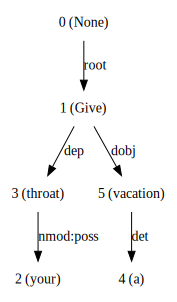

In [38]:
try:
    graph = graphviz.Source(list(smokeDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

#### "Come to Marlboro Country."

In [47]:
smokeDepParse = list(stanford.depParser.parse_sents(smokeDF['sentences'][53]))

In [48]:
targetSentence = 0
print(' '.join(smokeDF['sentences'][53][targetSentence]))

Come to Marlboro Country


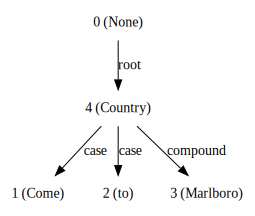

In [49]:
try:
    graph = graphviz.Source(list(smokeDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

#### "Gee, Mommy you sure enjoy your Marlboro."

In [50]:
smokeDepParse = list(stanford.depParser.parse_sents(smokeDF['sentences'][14]))

In [51]:
targetSentence = 0
print(' '.join(smokeDF['sentences'][14][targetSentence]))

Gee , Mommy you sure enjoy your Marlboros


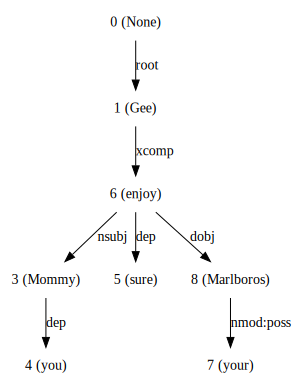

In [52]:
try:
    graph = graphviz.Source(list(smokeDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

## Anti-smoking Slogans

#### "Be a fighter; Put down your lighter."

In [56]:
antiDepParse = list(stanford.depParser.parse_sents(antiDF['sentences'][1]))

In [57]:
targetSentence = 0
print(' '.join(antiDF['sentences'][1][targetSentence]))

Be A Fighter ; Put Down The Lighter .


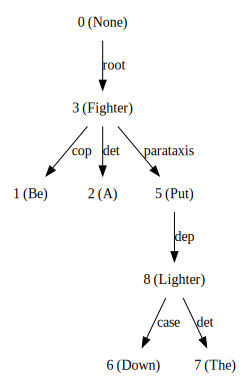

In [58]:
try:
    graph = graphviz.Source(list(antiDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

#### "Smoking batters your health, no-smoking betters your health."

In [59]:
antiDepParse = list(stanford.depParser.parse_sents(antiDF['sentences'][40]))

In [60]:
targetSentence = 0
print(' '.join(antiDF['sentences'][40][targetSentence]))

Smoking batters your health .


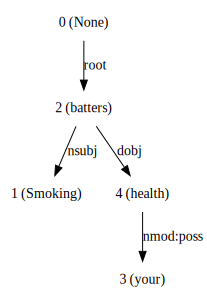

In [61]:
try:
    graph = graphviz.Source(list(antiDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

In [62]:
targetSentence = 1
print(' '.join(antiDF['sentences'][40][targetSentence]))

No-Smoking Betters your health .


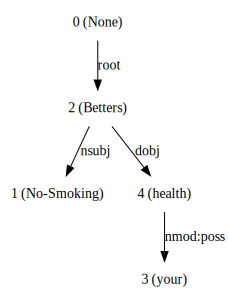

In [63]:
try:
    graph = graphviz.Source(list(antiDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

#### "Lions, and Tigers and Bears oh my… Drinking and Smoking and Drugs? "

In [64]:
antiDepParse = list(stanford.depParser.parse_sents(antiDF['sentences'][23]))

In [65]:
targetSentence = 0
print(' '.join(antiDF['sentences'][23][targetSentence]))

Lions , and Tigers and Bears oh my… Drinking and Smoking and Drugs ?


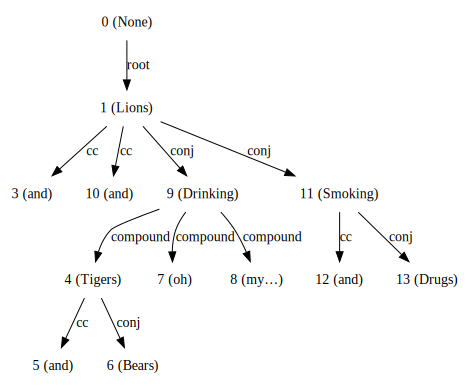

In [66]:
try:
    graph = graphviz.Source(list(antiDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

### Analyzing the Structures

Based on our dependency parsing structure tree shown above, I concludes five siginificant features of advertising slogans and anti-smoking slogans.

1) The most significant feature of both advertising slogans and anti-smoking slogans is that they use very **simple verb phrase** to complete a sentences, which makes most of the slogans imperative sentences, like *"give your throat a vocation"* and *"Be a fighter, put down the lighter"*. This sentence structure reveals features of slogan: strong emotion, active, easy to read and memory.

2) For adversiting slogans, another feature is that it tries to **build a relation between products and target costumers**. The famous slogan of *"Gee, Mommy you sure enjoy your Marlboro"* is an example. In this sentence, the nominal subject **Mommy** is connected with the direct object **Marlboro** with the movement **enjoy**. Since this slogan is created under the background that Marlboro had beed repositioned to appeal new generation mothers after WW2, we can see that the it intentionally built a relation between its target population and the product.

3) For anti-smoking slogans, a feature that different from advertising slogans is that it tries to combine two or more simple verb phrase into one slogan, to **make a comparison between smoking and non-smoking**, like the *"Smoking batters your health, no-smoking betters your health"*. In such sentences, the verb and adjective go with smoking are always negative, while the ones go with non-smoking are positive.

4) In these two kinds of slogans, we can see that different verbs are going with the same subject - smoking (or cigarettes). In our examples, in advertising slogans, verbs related to smoking or cigarettes are enjoy, give and betters, while verbs in anti-smoking are put down and batters. The former is positive, the latter is negative.

5) Collocation of nouns in these two kinds of slogans is actually making analogies of smoking. Therefore, we can observe the attitude towards smoking in different slogans. In advertising slogans, the noun co-occuring with (i.e. analogies to) smoking is vocation, while in anti-smoking slogans, the noun co-occuring with smoking is "drinking", "drugs", "tigers", etc. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?) How could these approaches inform your research project?

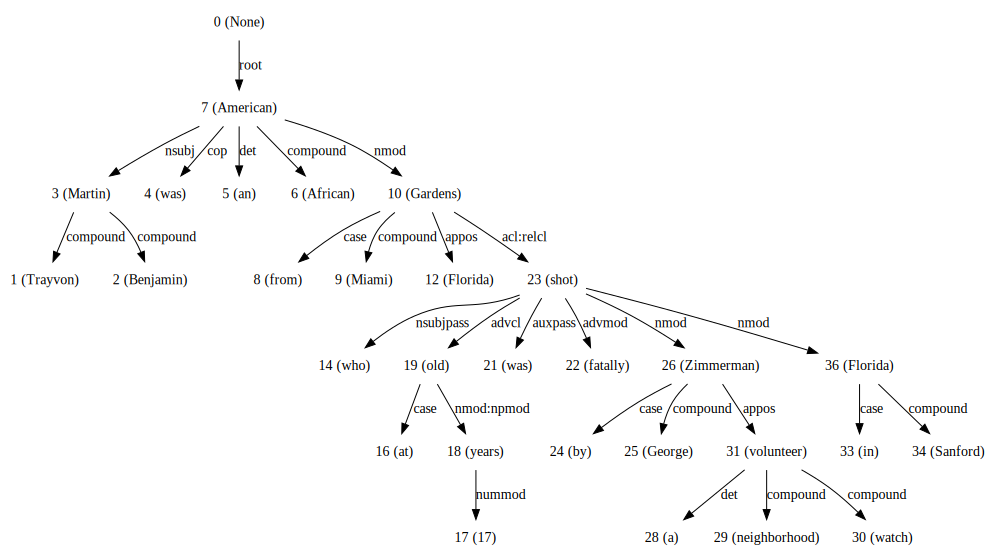

In [107]:
try:
    graph = graphviz.Source(list(depParses[3])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

In [103]:
text = ['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [nltk.word_tokenize(t) for t in text]
print('\n'.join(text))

I saw the elephant in my pajamas.
The quick brown fox jumped over the lazy dog.
While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.
Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo


In [104]:
ieDF = stanford.openIE(text)

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 36.434 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [39.5 sec].
[main] INFO edu.stanford.nlp.pip

In [105]:
ieDF

,certainty,subject,verb,object
0,1.0,elephant,is in,my pajamas
1,1.0,I,saw,elephant in my pajamas
2,1.0,I,saw,elephant
3,1.0,quick brown fox,jumped over,lazy dog
4,1.0,quick brown fox,jumped over,dog
5,1.0,quick fox,jumped over,dog
6,1.0,fox,jumped over,dog
7,1.0,brown fox,jumped over,lazy dog
8,1.0,brown fox,jumped over,dog
9,1.0,quick fox,jumped over,lazy dog


In [108]:
ieDF[ieDF['subject'] == 'Martin']['verb'].value_counts()

was    1
Name: verb, dtype: int64

In [118]:
ieDF[ieDF['subject'] == 'Trayvon Benjamin Martin']['subject'].value_counts()

Trayvon Benjamin Martin    4
Name: subject, dtype: int64

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa. Describe how you would select among these statements to create a database of high-value statements for your project and then do it by extracting relevant statements into a pandas dataframe.

## Advertisement Slogans

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior.

In [69]:
ieDF = stanford.openIE(smokeDF['slogan-text'][0])

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.2 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 15.188 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [16.7 sec].
[main] INFO edu.stanford.nlp.pip

In [70]:
ieDF

,certainty,subject,verb,object
0,1.0,More doctors,smoke Camels than,other cigarette
1,1.0,doctors,smoke Camels than,other cigarette


In [71]:
smokeStr = smokeDF['slogan-text'].to_string(index=False)

In [73]:
ieDF = stanford.openIE(smokeStr)

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 13.874 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [15.4 sec].
[main] INFO edu.stanford.nlp.pip

In [74]:
ieDF

,certainty,subject,verb,object
0,1.000000,your throat,reacts to,delightfully
1,1.000000,Your T-Zone,will tell,you
2,1.000000,They,'re,smooth
3,1.000000,They,'re smooth on,my throat
4,1.000000,Camels,agree with,your throat
5,1.000000,It,has,psychological
6,1.000000,Ivory tips,protect,lips
7,1.000000,flavor,protects,throat
8,1.000000,finest flavor,protects,throat
9,1.000000,Luckies,are,easy


Lets find at the most common subject in this story

In [75]:
ieDF['subject'].value_counts()

Luckies                      6
They                         5
they                         5
You                          5
I                            4
Kools                        2
Chesterfield                 2
holiday throats              2
flavor                       2
America                      1
It                           1
Your T-Zone                  1
heart                        1
Your throat                  1
largest selling cigarette    1
men                          1
Camels                       1
mild men                     1
finest flavor                1
throat                       1
your throat                  1
Ivory tips                   1
Name: subject, dtype: int64

The most common subjects are **entities that refer to cigarettes** (Luckies, they, Kools, Chesterfield, Camels, etc).

In [125]:
ieDF['object'].value_counts()

your throat          3
my throat            2
you                  2
throat               2
easy                 1
clean fresh taste    1
my mouth             1
sweets               1
clean taste          1
delightfully         1
psychological        1
content              1
kind                 1
Lucky                1
America 's col.      1
always kind          1
fresh taste          1
col.                 1
best                 1
lips                 1
light                1
smooth               1
my voice             1
taste                1
Name: object, dtype: int64

The most common objects are entities that refer to or related to health issues, like "your throat", "my throat", "my mouth".

Let's check if words about health issue are objects of cigarettes.

In [76]:
ieDF[ieDF['subject'] == 'Luckies']['object'].value_counts()

your throat    2
easy           1
my throat      1
always kind    1
kind           1
Name: object, dtype: int64

In [79]:
ieDF[ieDF['subject'] == 'Camels']['object'].value_counts()

your throat    1
Name: object, dtype: int64

The answer is yes. **Cigarettes and health** are significant and often related subject-object in advertising slogans.

So, let's look into what verbs connects this pair of subject and object

In [80]:
ieDF['verb'].value_counts()

are                   6
leave                 4
're                   3
Got                   2
protect               2
to                    2
protects              2
get                   2
need                  2
go                    1
is best for           1
agree with            1
in                    1
kind to               1
are easy on           1
leave taste in        1
lot                   1
reacts to             1
is in                 1
go on                 1
will tell             1
are kind to           1
is                    1
are soothing to       1
will like             1
're smooth on         1
light                 1
has                   1
are always kind to    1
smoke                 1
Name: verb, dtype: int64

In [82]:
ieDF[ieDF['subject'] == 'Luckies']['verb'].value_counts()

are                   3
are easy on           1
are kind to           1
are always kind to    1
Name: verb, dtype: int64

In [83]:
ieDF[ieDF['object'] == 'your throat']['verb'].value_counts()

kind to               1
are kind to           1
are always kind to    1
agree with            1
Name: verb, dtype: int64

Verbs (or verb phrases) between cigarettes and health are **are easy on, are kind to, agree with**.

The statement I extracts from the advertising slogans is that **cigarettes (or smoking) is good to health**.

## Anti-smoking Slogans

Based on what I extracted from the advertising slogans, I want to figure out that 

1) If anti-smoking slogans also makes statements about the relationship between cigarettes (or smoking) and health

2) Whether and how its statement differs from advertising slogans?

In [84]:
antiStr = antiDF['slogan-text'].to_string(index=False)

In [85]:
antiIeDF = stanford.openIE(antiStr)

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.4 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 15.975 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [17.8 sec].
[main] INFO edu.stanford.nlp.pip

In [86]:
antiIeDF

,certainty,subject,verb,object
0,1.000000,you,swallow,it
1,0.845189,tobacco,Be,Fighter
2,1.000000,tobacco,kills,Fighter
3,1.000000,Cigarettes,are killers,travel in packs
4,1.000000,Cigarettes,are killers,travel
5,1.000000,Cigarettes,burn,holes
6,1.000000,Cigarettes,burn holes in,your pocket
7,1.000000,your mouth,is on,fire
8,1.000000,Everyone,has,right to air
9,1.000000,Everyone,has,right


In [88]:
antiIeDF['subject'].value_counts()

Cigarettes            4
you                   4
Smoking               3
Everyone              3
Tobacco companies     2
tobacco               2
cigarettes            2
Smoke                 2
Smoking cigarettes    2
your                  1
quitter               1
Smokers               1
Smoke worries         1
cigarette             1
Lions                 1
Cigarette             1
I                     1
Think                 1
No-Smoking            1
someone               1
Your money            1
smoking               1
my kids               1
your mouth            1
Our planet            1
roads                 1
it                    1
Name: subject, dtype: int64

As we can see, the most common subjects in anti-smoking slogans are also entities related to cigarettes or smoking (cigarettes, smoking, smoke, tobacco, smoker)!

In [96]:
antiIeDF['object'].value_counts()

you                     3
it                      2
so yesterday            2
yesterday               2
your                    2
Fighter                 2
your Health             2
smoking                 2
slow death              1
holes                   1
your health             1
travel in packs         1
travel                  1
their customers         1
right                   1
right to air            1
smoke                   1
fire                    1
lungs                   1
jokers                  1
governm                 1
then fool               1
me                      1
y.                      1
their best customers    1
your pocket             1
cool                    1
overcrowded             1
dead                    1
fool                    1
right to clean air      1
death                   1
bad                     1
Name: object, dtype: int64

In [93]:
antiIeDF[antiIeDF['subject'] == 'Smoking']['object'].value_counts()

your Health    2
your health    1
Name: object, dtype: int64

The subject of smoking is also related to the object of health

In [378]:
antiIeDF[antiIeDF['object'] == 'your Health']['verb'].value_counts()

fail      1
scares    1
Name: verb, dtype: int64

In [98]:
antiIeDF[antiIeDF['object'] == 'your health']['verb'].value_counts()

injures    1
Name: verb, dtype: int64

In [101]:
antiIeDF[antiIeDF['subject'] == 'Smoking']['verb'].value_counts()

injures    1
scares     1
fail       1
Name: verb, dtype: int64

In [102]:
antiIeDF[antiIeDF['subject'] == 'Cigarettes']['verb'].value_counts()

are killers      2
burn             1
burn holes in    1
Name: verb, dtype: int64

However, the verbs that connect subject "smoking" and object "health" in anti-smoking slogans are totally opposite to advertising slogans, such as **fail**, **scares**, **injures** and **are killers**.

Therefore, the statement I extract from anti-smoking slogans are **smoking (or cigarettes) are bad to health**.

### Extracting Statements into Pandas Dataframe

## Conclusion

In conclusion, based on the statement that I extracted from cigarettes advertising slogans and anti-smoking slogans, the stories behinds these two kinds of slogans are different. Suprisingly, they both trying to construct a statement about the relationship between smoking and health in their narratives. However, while the statement of advertising slogans is **Smoking is good to health**, the statement of anti-smoking slogans is **Smoking is bad to health**.

By claiming that smoking is good to health, what the cigarettes company trying to do is to legitimizing smoking, which can finally contribute to the cigarettes marketing. However, anti-smoking slogans aim to de-legitimizing smoking by emphasizing on smoking's bad effect on health.

Therefore, we can see that the important thing here is not whether smoking is good or bad for our health. What matters here is how people interpret cigarettes and smoking and how they make other people believes their statements. This feature of slogans can be also generalized to lots of issues like political campaign and propaganda and social movement.